<h1 align='center'>Capstone Project</h1>
<h2 align='center'>The Battle of Neighborhoods - Analyzing Coffee Shops in Portland, Oregon </h2>

## Introduction
Opening a coffee shop is a dream business for many people. Because it is a business that can make highly profitable, just making a great coffee. While a great coffee is the heart of business, location of the shop is also most important thing to consider too. Because if you choose the wrong location, in other words, choose a location that is not the target group, or a location in an area with a lot of competitors, this may cause your sales will not meet the target.
  
So, If someone considering to open a coffee shop, what type of place will be a good location to start a business? It will be great if we can have this information combined with a map of a city or a location of interest. The main goal of this project will be exploring the coffee shops in Portland, Oregon and combine with an key indicators of each area, to extract some insights so people that want to open a new coffee shop can scope down the point of interest and make them have a decision easier. 

## Dataset
The main dataset we will use in this notebook will be the US Household Income Statistics from Golden Oak Research Group from Kaggle's website. The database contains about 32,000 records on US Household Income Statistics & Geo Locations. A full description of the dataset can be found on [Kaggle's website](https://www.kaggle.com/goldenoakresearch/us-household-income-stats-geo-locations). In this notebook, we will use only some variables about key indicators of the economic and the area's coordinates in the dataset.  
  
The area's coordinates in the main dataset will be used to acquire venues information from Foursquare API. We will get some information about all venues in each given coordinates including venues identification, names, their coordinates, distance from the defined coordinates and categories.

## Table of Contents
1. **Import, Explore and Cleaning Dataset**  
2. **Getting Venues Data**  
3. **Clustering Area**  
4. **Examine Clusters**  
5. **Visualizing Results**  
6. **Conclusion**  

## Importing Libraries

In [1]:
import pandas as pd # library for data manipulation and analysis
import numpy as np # library support for large, multi-dimensional arrays and matrices
import chardet # library for detecting the character encoding
from geopy import Nominatim # convert an address into a coordinates
import folium # map rendering
import requests # library use to handle requests
import json # handle json file
from sklearn.preprocessing import StandardScaler # use to normalize the data
from sklearn.cluster import KMeans # algorithm use to grouping the data

# handle plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
mpl.style.use('ggplot')

## 1. Import, Explore and Cleaning Dataset

#### 
First, let's load the data. But since the csv file is not the default encoding, so we have to detect the file's encoding using the library chardet and then pass the parameter of the encoding into the read_csv function.

In [2]:
with open('US_Household_Income.csv', 'rb') as f:
    result = chardet.detect(f.read()) # detecting the character encoding 

df = pd.read_csv('../data/US_Household_Income.csv', encoding=result['encoding']) # pass the encoding parameter into the function

#### 
Select only necessary columns for reducing size of the dataframe.

In [3]:
df_selected = df[['State_Name', 'County', 'City', 'ALand', 'Lat', 'Lon', 'Mean']]

print('{} Rows'.format(df_selected.shape[0])) # check the number of samples in the dataset
df_selected.head()

32526 Rows


,State_Name,County,City,ALand,Lat,Lon,Mean
0,Alabama,Mobile County,Chickasaw,10894952,30.771450,-88.079697,38773
1,Alabama,Barbour County,Louisville,26070325,31.708516,-85.611039,37725
2,Alabama,Shelby County,Columbiana,44835274,33.191452,-86.615618,54606
3,Alabama,Mobile County,Satsuma,36878729,30.874343,-88.009442,63919
4,Alabama,Mobile County,Dauphin Island,16204185,30.250913,-88.171268,77948


In [4]:
state = df_selected.groupby(['State_Name']).count().shape[0] # number of all state in the dataset
county = df_selected.groupby(['County']).count().shape[0] # number of all county in the dataset
city = df_selected.groupby(['City']).count().shape[0] # number of all city in the dataset

print('There are {} State, {} County, {} City'.format(state, county, city))

There are 52 State, 1133 County, 8128 City


#### 
Since we will be focused only the venues in Portland, Oregon. So we filter out only those data to reducing size of the dataframe.

In [5]:
portland_raw = df_selected[(df_selected['State_Name'] == 'Oregon') & (df_selected['City'] == 'Portland')]

print('{} Areas, {} Unique Areas'.format(portland_raw.shape[0], len(portland_raw['Lat'].unique()))) # check for any duplicates
portland_raw.head()

64 Areas, 58 Unique Areas


,State_Name,County,City,ALand,Lat,Lon,Mean
23905,Oregon,Baker County,Portland,2034574,45.445405,-122.574608,33175
24061,Oregon,Baker County,Portland,3550610,45.466108,-122.657984,95511
24062,Oregon,Baker County,Portland,2270906,45.483252,-122.632743,40640
24064,Oregon,Baker County,Portland,1356651,45.483479,-122.614332,100338
24065,Oregon,Baker County,Portland,1436905,45.483697,-122.584946,53122


#### 
There are 64 rows in the dataset, but 58 unique. That's mean there are 6 duplicates.

#### 
Remove the duplicates, by combining each pair into one rows.

In [6]:
portland_raw['Area'] = range(portland_raw.shape[0]) # define an area (to makes order) to each rows
aggregation_func = {'Mean': 'mean', 'State_Name': 'first', 'County': 'first', 'City': 'first', 
                    'ALand': 'first', 'Lon': 'first', 'Area': 'first'} # define an aggregation function to each columns
portland = portland_raw.groupby('Lat', as_index=False).aggregate(aggregation_func).reindex(columns=portland_raw.columns)
portland.sort_values(['Area'], inplace=True) # reordering
portland.reset_index(drop=True, inplace=True) # reset the index, since some row was dropped
portland['Area'] = range(portland.shape[0]) # redefine an area

print('{} Areas, {} Unique Areas'.format(portland.shape[0], len(portland['Lat'].unique()))) # check for any duplicates
portland.head()

58 Areas, 58 Unique Areas


,State_Name,County,City,ALand,Lat,Lon,Mean,Area
0,Oregon,Baker County,Portland,2034574,45.445405,-122.574608,33175.0,0
1,Oregon,Baker County,Portland,3550610,45.466108,-122.657984,95511.0,1
2,Oregon,Baker County,Portland,2270906,45.483252,-122.632743,40640.0,2
3,Oregon,Baker County,Portland,1356651,45.483479,-122.614332,100338.0,3
4,Oregon,Baker County,Portland,1436905,45.483697,-122.584946,53122.0,4


#### 
Now, we can see the area and unique area are the same number, which mean that there is no duplicate left in the dataset. 

## 2. Getting Venues Data 

#### 
First, let's get the latitude and longitude values of 'Portland, Oregon'.

In [7]:
address = 'Portland, Oregon, USA'
geolocator = Nominatim(user_agent='pl_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('Portland, Oregon Coordinates: {}, {}'.format(latitude, longitude))

Portland, Oregon Coordinates: 45.5202471, -122.6741949


#### 
Let's visualize the center of each area in the city and their covered area which we will get all venues that located in this area. By using coordinates from the dataset and use Portland coordinates as the center of the map.

In [8]:
# create the map
portland_area_map = folium.Map(location=[latitude, longitude], zoom_start=11) # Portland, Oregon as center of the map

# add the circle to display the area around each area center in the map
for lat, lon in zip(portland['Lat'], portland['Lon']):
    folium.Circle(                      # use circle marker the make the unit of radius parameter as meters
        location=[lat, lon],            # coordinates from the dataset
        radius=1000,                    # 1000 meters around the center of each area
        color='black',
        fill_color='lightgray',
        fill_opacity=0.7
    ).add_to(portland_area_map)

# visualizing map
portland_area_map

#### 
Note that we set a radius equal to 1000 meters because we want to get as much venue as we can. But this cause an overlapping as we can see in the figure. We will deal with this overlapping later.

#### 
Define Foursquare credentials, version, radius and limit.

In [9]:
CLIENT_ID = 'RANTRTMBVOQOIHLZLEXAH3CXS5WJWVEWZCO0OL0U5EA5NTAX' # Foursquare ID
CLIENT_SECRET = '53TB4P3VBOZTCQFMKSJ2NAXHVYI5G5KDR5OONTEMTANKW2Y3' # Foursquare Secret
VERSION = '20180605' # API Version
RADIUS = 1000 # Radius around the defined coordinate
LIMIT = 200 # Limit of the results

#### 
Get the venues in Portland within a radius of 1000 meters from each area.

In [10]:
venues_list = [] # create a list that we will use to append a row of venue

for area, lat, lon in zip(portland['Area'], portland['Lat'], portland['Lon']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, RADIUS, LIMIT)
    result = requests.get(url).json()['response']['groups'][0]['items']
    # get only releveant information for each venue
    for venue in result:
        venues_list.append([area, lat, lon,
        venue['venue']['id'],
        venue['venue']['name'],
        venue['venue']['location']['lat'],
        venue['venue']['location']['lng'],
        venue['venue']['location']['distance'],
        venue['venue']['categories'][0]['name']])

# create a dataframe
venue_col = ['Area', 'Latitude', 'Longitude', 'Venue ID', 'Venue Name', 'Lat', 'Lon', 'Venue Distance', 'Venue Categories']
portland_venues = pd.DataFrame(venues_list, columns=venue_col)

# check for any duplicates and visualize the dataframe
print('{} Venues, {} Unique Venues'.format(portland_venues.shape[0], len(portland_venues['Venue ID'].unique()))) 
portland_venues.head()

2942 Venues, 2404 Unique Venues


,Area,Latitude,Longitude,Venue ID,Venue Name,Lat,Lon,Venue Distance,Venue Categories
0,0,45.445405,-122.574608,4bedfe6d2c082d7f39e12f42,Sushi & Maki,45.444529,-122.577287,230,Sushi Restaurant
1,0,45.445405,-122.574608,4bbce6ddf57ba593cb67adb9,Mi Pueblo Mexican Restaurante,45.446845,-122.579992,449,Mexican Restaurant
2,0,45.445405,-122.574608,55e85ee2498ea4b132dc2018,Black Rock Coffee Bar,45.444364,-122.578467,322,Coffee Shop
3,0,45.445405,-122.574608,56e845fb498e7b8708f0e08f,Starbucks,45.447895,-122.579381,464,Coffee Shop
4,0,45.445405,-122.574608,4b64ad61f964a520acc72ae3,Penzeys Spices,45.442650,-122.577260,370,Gourmet Shop


#### 
We can see that there are about 500 duplicate venues due to overlapping. Let's remove this by sorting venue distance from center area ascending and keep the first duplicate (which have lowest distance compare to others duplicates) and sort the index to make the order not change.

In [11]:
# dropping duplicates
portland_venues_cleaned = portland_venues.sort_values('Venue Distance').drop_duplicates('Venue ID', keep='first').sort_index()
portland_venues_cleaned.reset_index(drop=True, inplace=True)

# check for any duplicates and visualize the dataframe
print('{} Venues, {} Unique Venues'.format(portland_venues_cleaned.shape[0], len(portland_venues_cleaned['Venue ID'].unique())))
portland_venues_cleaned.head()

2404 Venues, 2404 Unique Venues


,Area,Latitude,Longitude,Venue ID,Venue Name,Lat,Lon,Venue Distance,Venue Categories
0,0,45.445405,-122.574608,4bedfe6d2c082d7f39e12f42,Sushi & Maki,45.444529,-122.577287,230,Sushi Restaurant
1,0,45.445405,-122.574608,4bbce6ddf57ba593cb67adb9,Mi Pueblo Mexican Restaurante,45.446845,-122.579992,449,Mexican Restaurant
2,0,45.445405,-122.574608,55e85ee2498ea4b132dc2018,Black Rock Coffee Bar,45.444364,-122.578467,322,Coffee Shop
3,0,45.445405,-122.574608,56e845fb498e7b8708f0e08f,Starbucks,45.447895,-122.579381,464,Coffee Shop
4,0,45.445405,-122.574608,4b64ad61f964a520acc72ae3,Penzeys Spices,45.442650,-122.577260,370,Gourmet Shop


#### 
We will consider only coffee shop. So let's filter other categories out.

In [12]:
portland_coffee = portland_venues_cleaned[portland_venues_cleaned['Venue Categories'] == 'Coffee Shop']
portland_coffee.head()

,Area,Latitude,Longitude,Venue ID,Venue Name,Lat,Lon,Venue Distance,Venue Categories
2,0,45.445405,-122.574608,55e85ee2498ea4b132dc2018,Black Rock Coffee Bar,45.444364,-122.578467,322,Coffee Shop
3,0,45.445405,-122.574608,56e845fb498e7b8708f0e08f,Starbucks,45.447895,-122.579381,464,Coffee Shop
5,0,45.445405,-122.574608,53c90941498e10c40af0a044,Dutch Bros. Coffee,45.452033,-122.579411,827,Coffee Shop
37,0,45.445405,-122.574608,4adf79a6f964a520ee7a21e3,Starbucks,45.453889,-122.578803,999,Coffee Shop
68,1,45.466108,-122.657984,4a1f1959f964a520067c1fe3,Blue Kangaroo Coffee Roasters,45.467087,-122.653144,393,Coffee Shop


#### 
Let's see the location of coffee shops around Portland.

In [13]:
# create the map center around Portland
portland_coffee_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add circle marker to display all coffee shops in the map
for lat, lon in zip(portland_coffee['Lat'], portland_coffee['Lon']):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7
    ).add_to(portland_coffee_map)

# visualizing map
portland_coffee_map

#### 
Now, let's see how many coffee shops in each area.

In [14]:
aggregation_func = {'Venue Categories': 'count'} # define an aggregate function
coffee_count = portland_coffee.groupby('Area').aggregate(aggregation_func) # aggregate data by grouping into area

coffee_count.head()

,Venue Categories
Area,
0,4
1,2
2,2
3,2
4,3


#### 
And insert the result into the original dataframe.

In [15]:
portland['Coffee Shop'] = coffee_count['Venue Categories']
portland['Coffee Shop'] = portland['Coffee Shop'].fillna(0).astype(int) # if no coffee shops in the area (NaN), replace it by 0

portland.head()

,State_Name,County,City,ALand,Lat,Lon,Mean,Area,Coffee Shop
0,Oregon,Baker County,Portland,2034574,45.445405,-122.574608,33175.0,0,4
1,Oregon,Baker County,Portland,3550610,45.466108,-122.657984,95511.0,1,2
2,Oregon,Baker County,Portland,2270906,45.483252,-122.632743,40640.0,2,2
3,Oregon,Baker County,Portland,1356651,45.483479,-122.614332,100338.0,3,2
4,Oregon,Baker County,Portland,1436905,45.483697,-122.584946,53122.0,4,3


## 3. Clustering Area 

#### 
Selecting the feature that we will use in clustering and check for a missing value.

In [16]:
# selecting features
features = portland[['ALand', 'Mean', 'Coffee Shop']].values

# check for a missing value
if sum(sum(np.isnan(features))) == 0:
    print('No Missing Values')
else:
    print('Have Missing Values !!!')

No Missing Values


#### 
Let's normalize the data to make sure that every feature has the same weight in the clustering process and find the best number of cluster using the elbow method.

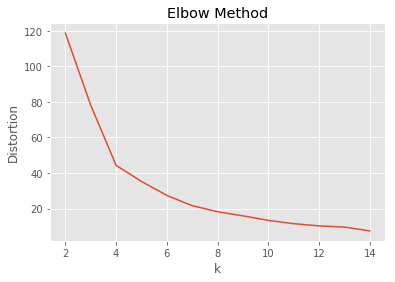

In [17]:
# standardize the data
x = StandardScaler().fit_transform(features) # removing the mean and scaling to unit variance

sse = [] # list of sum of square error
num_k = range(2,15)

# an elbow method
for k in num_k:
    k_means = KMeans(n_clusters=k, random_state=0).fit(x)
    sse.append(k_means.inertia_)
    
plt.plot(num_k, sse)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

#### 
The optimal k in the elbow function is at the elbow point in the graph. In this case, it is equal to 4. So we use 4 as number of cluster in clustering algorithm. After fitting, we insert the result into the original dataframe.

In [18]:
# fitting the data
k_means = KMeans(n_clusters=4, random_state=0).fit(x)

# insert the result into the original dataframe 
portland['Cluster'] = k_means.labels_
portland.head()

,State_Name,County,City,ALand,Lat,Lon,Mean,Area,Coffee Shop,Cluster
0,Oregon,Baker County,Portland,2034574,45.445405,-122.574608,33175.0,0,4,0
1,Oregon,Baker County,Portland,3550610,45.466108,-122.657984,95511.0,1,2,3
2,Oregon,Baker County,Portland,2270906,45.483252,-122.632743,40640.0,2,2,0
3,Oregon,Baker County,Portland,1356651,45.483479,-122.614332,100338.0,3,2,3
4,Oregon,Baker County,Portland,1436905,45.483697,-122.584946,53122.0,4,3,0


## 4. Examine Clusters

#### 
Let's visualizing each cluster with a barplot. We will separate the feature including average income, square area of land and number of coffee shop into each subplot. Each subplot will contain the summary of each cluster, each cluster will be located at the x-ticks in x-axis. On y-axis is the values of each feature. And dashes line in each subplot is a average value of each feature.

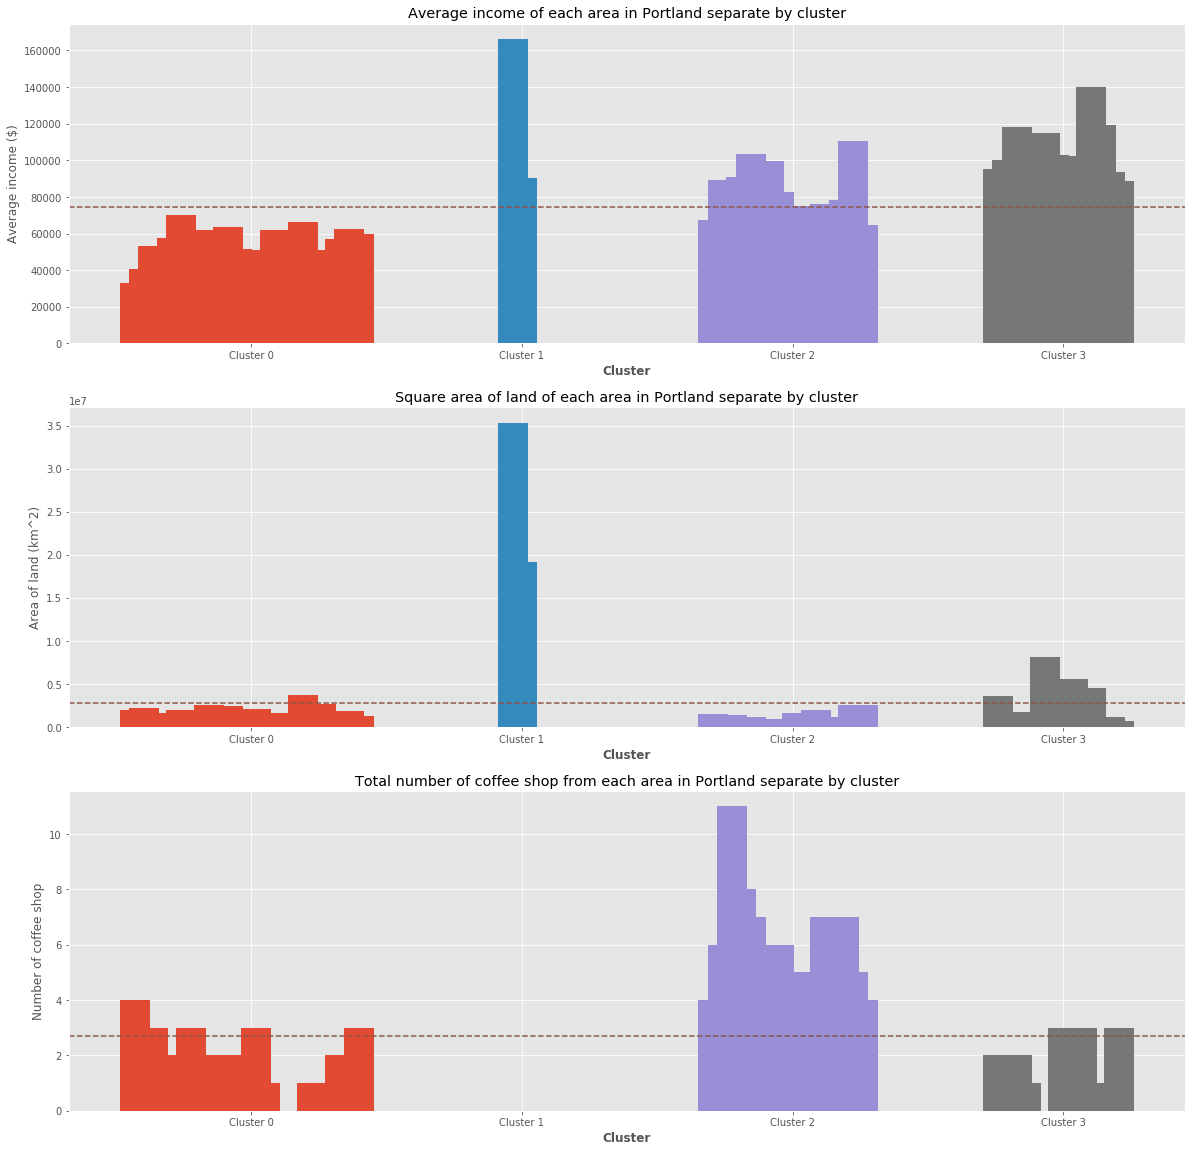

In [19]:
clus_dict = {} # define a dictionary of table of each cluster for plotting purposes
clus_order = ['zero', 'one', 'two', 'three'] # name format of each cluster in clus_dict
colname = ['Mean', 'ALand', 'Coffee Shop'] # column name use to call column of table in clus_dict
label_y = ['Average income ($)', 'Area of land (km^2)', 'Number of coffee shop'] # label of y-axis in each subplot
plottitle = ['Average income of each area in Portland separate by cluster',
             'Square area of land of each area in Portland separate by cluster',
             'Total number of coffee shop from each area in Portland separate by cluster']
barwidth = 0.25
# xticks distance use to separate a group of cluster in subplot = (24*0.25)+1 = 7
x_dist = (portland.groupby('Cluster').count().max().values[0])*barwidth+1 

fig = plt.figure(figsize=(20, 20))

# assign each table of each cluster into the dictionary
for ind, ord in enumerate(clus_order):
    clus_dict['cluster_{}'.format(ord)] = portland[portland['Cluster'] == ind] 

# plotting each subplot
for num_col, col in enumerate(colname):
    ax = fig.add_subplot(3,1,num_col+1)
    # plotting each cluster on each xticks
    for ind, ord in enumerate(clus_order):
        len_clus = len(clus_dict['cluster_{}'.format(ord)]) # length of samples in each cluster
        # x-axis: location of each bar for each cluster (for use cases): 
        # (location of xticks)-(half of the total bar length)+(bar location shift value for each samples)
        ax.bar(((x_dist/2+(x_dist*ind))-(len_clus*barwidth/2)+(barwidth*np.arange(len_clus))),
                 clus_dict['cluster_{}'.format(ord)][col]) # y-axis: each feature in each clusters

    ax.axhline(y=portland.mean()[col], color='#8c564b', linestyle='--') # mean of each feature
    ax.set_xlabel('Cluster', fontweight='bold')
    ax.set_xticks(x_dist/2+(x_dist*np.arange(len(clus_dict)))) # location of xticks = 3.5 + (0,1,2,3)*6
    ax.set_xticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
    ax.set_ylabel(label_y[num_col])
    ax.set_title(plottitle[num_col])

plt.show()

#### Now, let's take a look at summary of each cluster
Cluster 0: Below average household income, small area of land and have several coffee shops.  
Cluster 1: High household income, large area of land but no coffee shops.  
Cluster 2: Around average household income, small area of land and have many coffee shops.  
Cluster 3: High household income, medium area of land and have several coffee shops.

We can see that each cluster have a unique characteristics.

## 5. Visualizing Results

#### 
First, let's add a quantifier to a original dataframe. We will assign this quantifier into a label in a popup when plotting the map.

In [20]:
# assign a quantifier into new columns depend on the label of clusters
for num_row, clus in enumerate(portland['Cluster']):
    portland.loc[num_row, 'Income Qtf.'] = ['Below Average', 'High', 'Medium', 'High'][clus]
    portland.loc[num_row, 'ALand Qtf.'] = ['Small', 'Large', 'Small', 'Medium'][clus]
    portland.loc[num_row, 'Coffee Shop Qtf.'] = ['Several', 'No',  'Many', 'Several'][clus]

portland.head()

,State_Name,County,City,ALand,Lat,Lon,Mean,Area,Coffee Shop,Cluster,Income Qtf.,ALand Qtf.,Coffee Shop Qtf.
0,Oregon,Baker County,Portland,2034574,45.445405,-122.574608,33175.0,0,4,0,Below Average,Small,Several
1,Oregon,Baker County,Portland,3550610,45.466108,-122.657984,95511.0,1,2,3,High,Medium,Several
2,Oregon,Baker County,Portland,2270906,45.483252,-122.632743,40640.0,2,2,0,Below Average,Small,Several
3,Oregon,Baker County,Portland,1356651,45.483479,-122.614332,100338.0,3,2,3,High,Medium,Several
4,Oregon,Baker County,Portland,1436905,45.483697,-122.584946,53122.0,4,3,0,Below Average,Small,Several


#### 
Let's visualize the area separate by cluster. The color of a marker show that there are different group of clusters. Notice that we didn't use latitude and longitude as a features in the algorithm. But we can see each area in the same cluster seems to be close to each other in some side of a city and a little mixed in some part significantly.

In [21]:
# create the map center around Portland
portland_clus_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# define color array for each cluster
rgbcol = cm.gnuplot(np.linspace(0, 1, len(clus_dict)))
rainbow = [colors.rgb2hex(col) for col in rgbcol]

# add circle marker with a popup to display each area center and it's information in the map
for lat, lon, clus, ar, inc, ld, cf in zip(portland['Lat'], portland['Lon'], portland['Cluster'], portland['Area'],
                                           portland['Income Qtf.'], portland['ALand Qtf.'], portland['Coffee Shop Qtf.']):
    label = folium.Popup('Area: '+str(ar)+' / Average Income: '+str(inc)+' / Area Size: '+ 
                          str(ld)+' / '+str(cf)+' Coffee Shop.', parse_html=True, max_width=500)
    folium.CircleMarker(
        location=[lat, lon],
        radius=7,
        popup=label,
        color=rainbow[clus], # different color for different cluster
        fill=True,
        fill_color=rainbow[clus], # different color for different cluster
        fill_opacity=0.7
    ).add_to(portland_clus_map)

# visualizing map
portland_clus_map

#### 
Finally, we will visualize each area center with a coffee venues of their group in the same map. Let's insert the cluster label in the portland coffee venues table so we can call this column to use them separate the color of markers for each cluster in the map.

In [22]:
# reset the index so we can iterate through each row in order
portland_coffee.reset_index(drop=True, inplace=True)

# assign a cluster label to each specific coffee shop depend on the area
for num_row, area in enumerate(portland_coffee['Area']):
    portland_coffee.loc[num_row, 'Cluster'] = portland.loc[area, 'Cluster']

portland_coffee['Cluster'] = portland_coffee['Cluster'].astype(int)
portland_coffee.head()

,Area,Latitude,Longitude,Venue ID,Venue Name,Lat,Lon,Venue Distance,Venue Categories,Cluster
0,0,45.445405,-122.574608,55e85ee2498ea4b132dc2018,Black Rock Coffee Bar,45.444364,-122.578467,322,Coffee Shop,0
1,0,45.445405,-122.574608,56e845fb498e7b8708f0e08f,Starbucks,45.447895,-122.579381,464,Coffee Shop,0
2,0,45.445405,-122.574608,53c90941498e10c40af0a044,Dutch Bros. Coffee,45.452033,-122.579411,827,Coffee Shop,0
3,0,45.445405,-122.574608,4adf79a6f964a520ee7a21e3,Starbucks,45.453889,-122.578803,999,Coffee Shop,0
4,1,45.466108,-122.657984,4a1f1959f964a520067c1fe3,Blue Kangaroo Coffee Roasters,45.467087,-122.653144,393,Coffee Shop,3


#### 
Let's visualize the result. Each color of the markers represent the different group of clusters. Big circle represent the center of each area, and a small circle represent the coffee shops.

In [23]:
# create the map center around Portland
portland_combine_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add circle marker with a popup to display each area center and it's information in the map
for lat, lon, clus, ar, inc, ld, cf in zip(portland['Lat'], portland['Lon'], portland['Cluster'], portland['Area'],
                                           portland['Income Qtf.'], portland['ALand Qtf.'], portland['Coffee Shop Qtf.']):
    label = folium.Popup('Area: '+str(ar)+' / Average Income: '+str(inc)+' / Area Size: '+ 
                          str(ld)+' / '+str(cf)+' Coffee Shop.', parse_html=True, max_width=500)
    folium.CircleMarker(
        location=[lat, lon],
        radius=8,
        popup=label,
        color=rainbow[clus],
        fill=True,
        fill_color=rainbow[clus],
        fill_opacity=0.7
    ).add_to(portland_combine_map)

# add circle marker to display all coffee shops in the map separate by cluster
for lat, lon, clus in zip(portland_coffee['Lat'], portland_coffee['Lon'], portland_coffee['Cluster']):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2.5,
        color=rainbow[clus],
        fill=True,
        fill_color='white',
        fill_opacity=0.7
    ).add_to(portland_combine_map)

# visualizing map
portland_combine_map

## 6. Conclusion
In this project, we have gone through the process of defining business problem, identify and gather the data required, explore and prepare data for modeling, segmenting and clustering, and examine the results. We have clustered the area on Portland into 4 groups, each have their unique characteristics. For the problem defined in the business problem step, if we look at the map, we can say that the best answer could be Cluster 3 of the yellow markers in the map with target of high average income, medium land area size and several coffee shop for not much competitors as it should be. Therefore, these are just primary analysis purpose to scope down the point of interest and make people who want to open a coffee shop make a decision easier. There are much more additional factors to consider of, for example, target age range, your budget and/or environment around. Final decision can be made upon consider all of the factors and select the best place based on the requirement, situation and constraint.